In [1]:
from packages.Utility.DatasetReader import DatasetReader
from sklearn import svm
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from packages.Utility.Gabor import GaborFilterBanks
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Flatten, Activation, Layer, Dense
from keras import backend as K
from sklearn.model_selection import KFold
from keras.models import Model
from sklearn.externals import joblib
import cv2 as cv
import matplotlib.pyplot as plt
from scipy.spatial import distance
from packages.Utility.SVM import *
from packages.Utility.Kernel import *

Using TensorFlow backend.


In [2]:
dts = DatasetReader()
dts.resize((32, 32))
dts.binarization()
dataset = dts.getDataset('dataset/testing_digit')

# K-fold

In [3]:
kfold = KFold(n_splits = 3, shuffle = True)
fold = []

for train, test in kfold.split(dataset):
    fold.append([train, test])
    
fold = np.array(fold)
X_train = np.array([i[0] for i in dataset[fold[0, 0]]])
Y_train = np.array([i[2] for i in dataset[fold[0, 0]]])

# Custom Layer
Masih bingung

In [11]:
class SVMLayer(Layer):

    def __init__(self, output_dim, X, Y, model, **kwargs):
        self.output_dim = output_dim
        self.X = X
        self.Y = Y
        self.model = model
        super(SVMLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(SVMLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        # Mendefinisikan model
        model = Sequential()

        c1 = Conv2D(name='c1', filters = 6, kernel_size = 5, strides = 1, padding = 'valid',
                    activation = 'relu', input_shape = (32, 32, 1))
        c2 = Conv2D(name='c2', filters = 16, kernel_size = 5, strides = 1, padding = 'valid',
                    activation = 'relu')

        model.add(c1)
        model.add(MaxPool2D(pool_size = 2))
        model.add(c2)
        model.add(MaxPool2D(pool_size = 10))
        model.add(Flatten())
        
        model.get_layer('c1').set_weights(self.model.get_layer('c1').get_weights())
        model.get_layer('c2').set_weights(self.model.get_layer('c2').get_weights())
        features = model.predict(self.X)
        
        cls = svm.SVC(kernel = 'linear', max_iter = 10000, C = 100)
        cls.fit(features, self.Y.astype('int'))
        
        if K.is_placeholder(x):
            print('Yes !')
            pass
        else:
            print('No !')
            y_pred = cls.predict(np.array([K.eval(K.relu(x))]))
        
        return K.variable([1])

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 1)

# CNN
Compile CNN pada umumnya

In [4]:
model = Sequential()

c1 = Conv2D(name='c1', filters = 6, kernel_initializer = GaborFilterBanks(),
            kernel_size = 5, strides = 1, padding = 'valid', activation = 'relu', 
            input_shape = (32, 32, 1))
c2 = Conv2D(name='c2', filters = 16, kernel_initializer = GaborFilterBanks(), 
            kernel_size = 5, strides = 1, padding = 'valid', activation = 'relu')
m1 = MaxPool2D(pool_size = 2)
m2 = MaxPool2D(pool_size = 2)
f1 = Flatten(name = 'f1')
model.add(c1)
model.add(m1)
model.add(c2)
model.add(m2)
model.add(f1)
model.add(Dense(16, activation = 'sigmoid', name = 'd1'))
model.add(Dense(16, activation = 'sigmoid', name = 'd2'))
model.add(Dense(10, activation = 'softmax', name = 'd3'))
# model.add(SVMLayer(X = np.array([i[0] for i in dataset]), Y = dataset[:, 1], output_dim = (1), model = model, trainable = False))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs = 1, verbose = 1, batch_size = 100, validation_data = (X_train, Y_train))

Train on 6666 samples, validate on 6666 samples
Epoch 1/1
6666/6666 [==============================] - 114s 17ms/step - loss: 0.0899 - acc: 0.1127 - val_loss: 0.0891 - val_acc: 0.1578


In [ ]:
# model.save('trained/trained_digit.h5')
# model = load_model('trained/trained_digit.h5', custom_objects={'getGaborFilterBanks': getGaborFilterBanks()})

In [5]:
X_test = np.array([i[0] for i in dataset[fold[0, 1]]])
Y_test_cnn = np.array([i[2] for i in dataset[fold[0, 1]]])
Y_test_svm = np.array([i[1] for i in dataset[fold[0, 1]]])

## Menghitung Akurasi CNN
### Akurasi data training

In [6]:
predicted = model.predict(X_train)
y_pred = np.argmax(predicted, axis = 1)
y_true = dataset[fold[0, 0], 1].astype('int')

print(confusion_matrix(y_true, y_pred))
print(accuracy_score(y_true, y_pred))

[[  0 287   0  68 307   0   0   0   0   0]
 [  0 487   0   2 126   0   0 146   0   0]
 [  0 280   0   7 312   0   0  74   0   0]
 [  0 296   0 244 134   0   0  12   0   0]
 [  0   5   0   0 637   0   0   0   0   0]
 [  0 169   0 160 256   0   0   3   0   0]
 [  0 137   0   3 488   0   0   0   0   0]
 [  0  16   0   2 626   0   0  52   0   0]
 [  0 206   0   9 438   0   0   0   0   0]
 [  0   6   0   7 663   0   0   1   0   0]]
0.21302130213021303


### Akurasi data testing

In [7]:
predicted = model.predict(X_test)
y_pred = np.argmax(predicted, axis = 1)
y_true = Y_test_svm.astype('int')

print(confusion_matrix(y_true, y_pred))
print(accuracy_score(y_true, y_pred))

[[  0 147   0  36 135   0   0   0   0   0]
 [  0 237   0   0  68   0   0  69   0   0]
 [  0 152   0   3 160   0   0  44   0   0]
 [  0 131   0 115  72   0   0   6   0   0]
 [  0   2   0   0 337   0   0   1   0   0]
 [  0  81   0  87 136   0   0   0   0   0]
 [  0  50   0   2 276   0   0   2   0   0]
 [  0   8   0   4 294   0   0  26   0   0]
 [  0  98   0   4 219   0   0   0   0   0]
 [  0   0   0   3 328   0   0   1   0   0]]
0.21445710857828434


# Melakukan Pelatihan dengan SVM
data dari Flatten layer dilatih pada SVM dan
diuji akurasinya

In [7]:
feature_model = Model(
    inputs = model.input,
    outputs = model.get_layer('f1').output
)

features_train = feature_model.predict(X_train)

cls = SVM(C = 100, tol = 0.01)
cls.compile(max_passes = 2, max_iter = 5)
# cls = svm.SVC(kernel = 'linear', max_iter = 50000, C = 100)
cls.fit(features_train, dataset[fold[0, 0], 1].astype('int'))
# joblib.dump(cls, 'trained/trained_svm_digit.sav')


Fitting for class 0 and 1
Train on 1420 samples
acc: 0.87
--------------------------------------------------------------------------------
Fitting for class 0 and 2
Train on 1334 samples
acc: 0.51
--------------------------------------------------------------------------------
Fitting for class 0 and 3
Train on 1337 samples
Passes: 0/2 | Iteration: 1/5 | Index Data: 51/1337 | Time: 9.88s | Loss: 16.96

KeyboardInterrupt: 

## Akurasi SVM
### Data Training

In [248]:
# cls = joblib.load('trained/trained_svm_digit.sav')
y_pred = cls.predict(features_train)
y_true = dataset[fold[0, 0], 1].astype('int')

print(confusion_matrix(y_true, y_pred))
print(accuracy_score(y_true, y_pred))

[[407  50  32   1  11   0 134   1 138   4]
 [  9 843   3   0   2   2  16   0  14   2]
 [ 38  20 169 147 128 208   1 105   2  27]
 [  1  20  46 539  36  53   0  98   0   7]
 [ 35   9  66  84 275  57   5  86   2 158]
 [ 35  21 113 115  79 242   0  98   1  16]
 [ 82  20 130   0  36   1 447   1  57   2]
 [ 19   4  81  55 123  98   0 418   0  22]
 [276 104 128   4  63   2  45  10 118  32]
 [ 18  20  74  43 218  58   0  65   2 313]]
0.471375


### Data Testing

In [249]:
features_test = feature_model.predict(X_test)

y_pred = cls.predict(features_test)
y_true = dataset[fold[0, 1], 1].astype('int')

print(confusion_matrix(y_true, y_pred))
print(accuracy_score(y_true, y_pred))

[[120   9   2   0   4   0  27   2  38   0]
 [  1 227   2   1   0   0   5   1   7   0]
 [  3   5  36  36  38  46   0  19   0   4]
 [  1   7  14 139   7  22   0  17   0   3]
 [ 14   2  23  18  76  11   1  19   0  41]
 [  9   3  30  31  16  47   0  28   1   7]
 [ 17   6  35   0   7   1 106   0  10   0]
 [  8   3  16  11  28  31   0 104   0   7]
 [ 62  22  32   3  13   1  10   5  34  10]
 [  4   1  21  14  59  20   1  13   3  62]]
0.4755


# Retrieval Dengan SVM sebagai klasifikasi

Kueri acak

In [228]:
index_kueri = np.random.randint(X_test.shape[0])
kueri = X_test[index_kueri]

### Mendapatkan fitur dari data training

In [229]:
train_feature = feature_model.predict(X_train)

## Menggabungkan dengan dataset training

In [230]:
collection = np.append(dataset[fold[0, 0]], train_feature, axis = 1)

### Klasifikasi kueri

In [231]:
# cls = joblib.load('trained/trained_svm_digit.sav')
ftr = feature_model.predict(np.array([kueri]))
pred = cls.predict(ftr)

### Mendapatkan daftar citra sesuai hasil klasifikasi

In [232]:
box = collection[np.where(collection[:, 1] == pred[0])]

### Menghitung jarak

In [233]:
jarak = []

for i in range(box.shape[0]):
    jarak.append([box[i, 3], distance.euclidean(box[i, 4:], ftr)])
    
jarak.sort(key = lambda x: x[1])    

### Menampilkan hasil

Kelas kueri :  3
Prediksi :  3


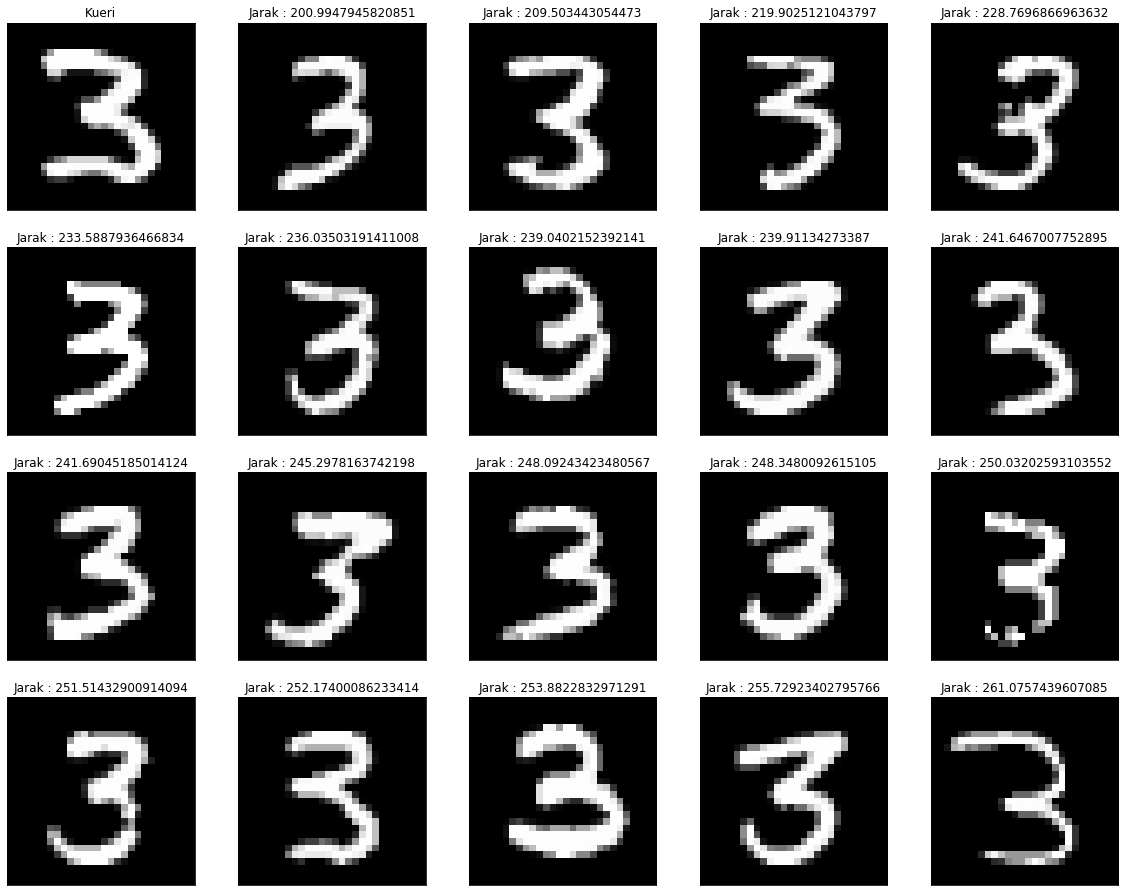

In [234]:
print('Kelas kueri : ', dataset[fold[0, 1]][index_kueri, 1])
print('Prediksi : ', pred[0])

fig = plt.figure(figsize = (20, 20))

## menampilkn query
y = fig.add_subplot(5, 5, 1)
y.imshow(
    cv.cvtColor(cv.imread(dataset[fold[0, 1]][index_kueri, 3]), cv.COLOR_BGR2RGB)
)
plt.title('Kueri')
y.axes.get_xaxis().set_visible(False)
y.axes.get_yaxis().set_visible(False)
    
for i in range(1, 20):
    y = fig.add_subplot(5, 5, i + 1)
    y.imshow(cv.cvtColor(cv.imread(jarak[i][0]), cv.COLOR_BGR2RGB))
    plt.title('Jarak : ' + str(jarak[i][1]))
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)